## Algorithm used - CNN and LSTM

In [1]:
import cv2
import os
import sys
import h5py
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.python.keras import backend
from tensorflow.keras.applications import VGG16
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Input, LSTM, Dense, Activation

## Loading data

In [2]:
# Frame size
img_size = 224

img_size_touple = (img_size, img_size)

# Number of channels (RGB)
num_channels = 3

# Flat frame size
img_size_flat = img_size * img_size * num_channels

# Number of classes for classification (Violence-No Violence)
num_classes = 2

# Number of files to train
_num_files_train = 1

# Number of frames per video
_images_per_file = 20

# Number of frames per training set
_num_images_train = _num_files_train * _images_per_file

# Video extension
video_exts = ".mp4"

## Extracting video frames

In [3]:
def extract_frames(file_path):
    images = []

    cap = cv2.VideoCapture(file_path)

    success, image = cap.read()
    count = 0
    while success and count < _images_per_file:
        rgb_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        resized = cv2.resize(rgb_img, dsize=(img_size, img_size), interpolation=cv2.INTER_CUBIC)
        images.append(resized)

        success, image = cap.read()
        count += 1

    result = np.array(images)
    result = result / 255
    result = result.astype(np.float16)

    return result

In [4]:
def create_labels(file_path):
    names = []
    labels = []

    for current, directory, file_names in os.walk(file_path):
        for file_name in file_names:
            if file_name.endswith(video_exts):
                if file_name.startswith("V"):
                    labels.append([1, 0])
                    names.append(f"{current}/" + file_name)
                elif file_name.startswith("NV"):
                    labels.append([0, 1])
                    names.append(f"{current}/" + file_name)

    name_lab = list(zip(names, labels))
    random.shuffle(name_lab)
    names, labels = zip(*name_lab)

    return names, labels

In [5]:
dir_path = "dataset/Real Life Violence Dataset"

In [6]:
names, labels = create_labels(dir_path)

In [7]:
frames = extract_frames(f"{names[0]}")

### Checking loaded image

In [8]:
visibility = (frames * 255).astype("uint8")

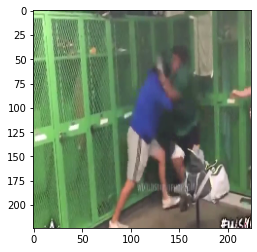

In [9]:
plt.imshow(visibility[3])

In [10]:
def print_progress(count, max_count):
    # Percentage completion.
    pct_complete = count / max_count

    # Status-message. Note the \r which means the line should
    # overwrite itself.
    msg = "\r- Progress: {0:.1%}".format(pct_complete)

    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush()

### Pre-Trained Model: VGG16 (CNN part)

In [11]:
image_model = VGG16(include_top=True, weights="imagenet")

In [12]:
image_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [13]:
transfer_layer = image_model.get_layer("fc2")

image_model_transfer = Model(inputs=image_model.input, outputs=transfer_layer.output)

transfer_value_size = backend.int_shape(transfer_layer.output)[1]

print(f"Input shape: {backend.int_shape(image_model.input)[1:3]}")
print(f"Output: {transfer_value_size}")

Input shape: (224, 224)
Output: 4096


In [14]:
def get_transfer_values(file_path):

    # Pre-allocate input-batch-array for images.
    shape = (_images_per_file,) + img_size_touple + (3,)

    image_batch = np.zeros(shape=shape, dtype=np.float16)

    image_batch = extract_frames(file_path)

    # Pre-allocate output-array for transfer-values.
    # Note that we use 16-bit floating-points to save memory.
    shape = (_images_per_file, transfer_value_size)
    transfer_values = np.zeros(shape=shape, dtype=np.float16)

    transfer_values = image_model_transfer.predict(image_batch)

    return transfer_values

In [15]:
def proces_transfer(vid_names, labels):

    count = 0

    tam = len(vid_names)

    # Pre-allocate input-batch-array for images.
    shape = (_images_per_file,) + img_size_touple + (3,)

    while count<tam:

        video_name = vid_names[count]

        image_batch = np.zeros(shape=shape, dtype=np.float16)

        image_batch = extract_frames(video_name)

         # Note that we use 16-bit floating-points to save memory.
        shape = (_images_per_file, transfer_value_size)
        transfer_values = np.zeros(shape=shape, dtype=np.float16)

        transfer_values = \
            image_model_transfer.predict(image_batch)

        labels1 = labels[count]

        aux = np.ones([20,2])

        labelss = labels1*aux

        yield transfer_values, labelss

        count+=1

In [16]:
def make_files(n_files, names_training, labels_training):

    gen = proces_transfer(names_training, labels_training)

    numer = 1

    # Read the first chunk to get the column dtypes
    chunk = next(gen)

    row_count = chunk[0].shape[0]
    row_count2 = chunk[1].shape[0]

    with h5py.File('prueba.h5', 'w') as f:

        # Initialize a resizable dataset to hold the output
        maxshape = (None,) + chunk[0].shape[1:]
        maxshape2 = (None,) + chunk[1].shape[1:]


        dset = f.create_dataset('data', shape=chunk[0].shape, maxshape=maxshape,
                                chunks=chunk[0].shape, dtype=chunk[0].dtype)

        dset2 = f.create_dataset('labels', shape=chunk[1].shape, maxshape=maxshape2,
                                 chunks=chunk[1].shape, dtype=chunk[1].dtype)

         # Write the first chunk of rows
        dset[:] = chunk[0]
        dset2[:] = chunk[1]

        for chunk in gen:

            if numer == n_files:

                break

            # Resize the dataset to accommodate the next chunk of rows
            dset.resize(row_count + chunk[0].shape[0], axis=0)
            dset2.resize(row_count2 + chunk[1].shape[0], axis=0)

            # Write the next chunk
            dset[row_count:] = chunk[0]
            dset2[row_count:] = chunk[1]

            # Increment the row count
            row_count += chunk[0].shape[0]
            row_count2 += chunk[1].shape[0]

            print_progress(numer, n_files)

            numer += 1

In [17]:
def make_files_test(n_files, names_test, labels_test):

    gen = proces_transfer(names_test, labels_test)

    numer = 1

    # Read the first chunk to get the column dtypes
    chunk = next(gen)

    row_count = chunk[0].shape[0]
    row_count2 = chunk[1].shape[0]

    with h5py.File('pruebavalidation.h5', 'w') as f:

        # Initialize a resizable dataset to hold the output
        maxshape = (None,) + chunk[0].shape[1:]
        maxshape2 = (None,) + chunk[1].shape[1:]


        dset = f.create_dataset('data', shape=chunk[0].shape, maxshape=maxshape,
                                chunks=chunk[0].shape, dtype=chunk[0].dtype)

        dset2 = f.create_dataset('labels', shape=chunk[1].shape, maxshape=maxshape2,
                                 chunks=chunk[1].shape, dtype=chunk[1].dtype)

         # Write the first chunk of rows
        dset[:] = chunk[0]
        dset2[:] = chunk[1]

        for chunk in gen:

            if numer == n_files:

                break

            # Resize the dataset to accommodate the next chunk of rows
            dset.resize(row_count + chunk[0].shape[0], axis=0)
            dset2.resize(row_count2 + chunk[1].shape[0], axis=0)

            # Write the next chunk
            dset[row_count:] = chunk[0]
            dset2[row_count:] = chunk[1]

            # Increment the row count
            row_count += chunk[0].shape[0]
            row_count2 += chunk[1].shape[0]

            print_progress(numer, n_files)

            numer += 1

In [18]:
training_set = int(len(names)*0.8)
test_set = int(len(names)*0.2)

names_training = names[:training_set]
names_test = names[training_set:]

labels_training = labels[:training_set]
labels_test = labels[training_set:]

In [83]:
make_files(training_set, names_training, labels_training)

- Progress: 99.9%

In [19]:
make_files_test(test_set, names_test, labels_test)

- Progress: 99.7%

In [19]:
def process_alldata_training_and_test(filename):

    joint_transfer=[]
    frames_num=20
    count = 0

    with h5py.File(filename, 'r') as f:

        X_batch = f['data'][:]
        y_batch = f['labels'][:]

    for i in range(int(len(X_batch)/frames_num)):
        inc = count+frames_num
        joint_transfer.append([X_batch[count:inc],y_batch[count]])
        count =inc

    data =[]
    target=[]

    for i in joint_transfer:
        data.append(i[0])
        target.append(np.array(i[1]))

    return data, target

In [20]:
data, target = process_alldata_training_and_test("prueba.h5")

In [21]:
data_test, target_test = process_alldata_training_and_test("pruebavalidation.h5")

In [26]:
data_train_size = int(len(data) * 0.9)
target_train_size = int(len(target) * 0.9)

data_train_size, target_train_size

(1415, 1415)

## LSTM Architecture

In [27]:
chunk_size = 4096
n_chunks = 20
rnn_size = 512

model = Sequential()
model.add(LSTM(rnn_size, input_shape=(n_chunks, chunk_size)))
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dense(50))
model.add(Activation('sigmoid'))
model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])

In [28]:
epoch = 200
batchS = 500

history = model.fit(np.array(data[:data_train_size]), np.array(target[:target_train_size]), epochs=epoch,
                    validation_data=(np.array(data[data_train_size:]), np.array(target[target_train_size:])),
                    batch_size=batchS, verbose=2)

Epoch 1/200
3/3 - 25s - loss: 0.3187 - accuracy: 0.4968 - val_loss: 0.2965 - val_accuracy: 0.5000
Epoch 2/200
3/3 - 11s - loss: 0.2804 - accuracy: 0.4933 - val_loss: 0.2535 - val_accuracy: 0.5000
Epoch 3/200
3/3 - 11s - loss: 0.2544 - accuracy: 0.5067 - val_loss: 0.2514 - val_accuracy: 0.5000
Epoch 4/200
3/3 - 11s - loss: 0.2485 - accuracy: 0.5258 - val_loss: 0.2517 - val_accuracy: 0.5000
Epoch 5/200
3/3 - 11s - loss: 0.2514 - accuracy: 0.4933 - val_loss: 0.2483 - val_accuracy: 0.6456
Epoch 6/200
3/3 - 12s - loss: 0.2487 - accuracy: 0.5717 - val_loss: 0.2497 - val_accuracy: 0.5000
Epoch 7/200
3/3 - 11s - loss: 0.2475 - accuracy: 0.5152 - val_loss: 0.2463 - val_accuracy: 0.5633
Epoch 8/200
3/3 - 12s - loss: 0.2458 - accuracy: 0.5442 - val_loss: 0.2444 - val_accuracy: 0.5506
Epoch 9/200
3/3 - 11s - loss: 0.2434 - accuracy: 0.6071 - val_loss: 0.2425 - val_accuracy: 0.5570
Epoch 10/200
3/3 - 11s - loss: 0.2390 - accuracy: 0.6155 - val_loss: 0.2366 - val_accuracy: 0.6392
Epoch 11/200
3/3 - 

## Model Evaluation

In [29]:
result = model.evaluate(np.array(data_test), np.array(target_test))

13/13 [==============================] - 6s 500ms/step - loss: 0.0512 - accuracy: 0.9415


In [30]:
for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.0512305311858654
accuracy 0.9414758086204529


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


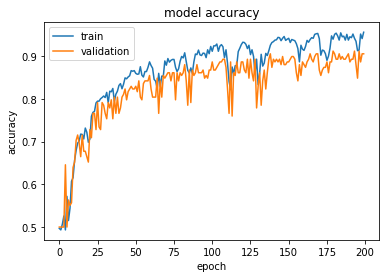

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


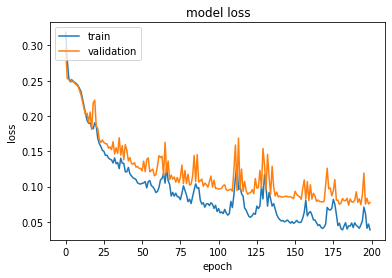

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path.eps', format='eps', dpi=1000)
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path1.eps', format='eps', dpi=1000)
plt.show()

In [32]:
model.save("saved_model_v5")

INFO:tensorflow:Assets written to: saved_model_v5\assets


In [32]:
history.history

{'loss': [0.3649003207683563,
  0.33536845445632935,
  0.28246015310287476,
  0.25295203924179077,
  0.2602084279060364,
  0.2553136944770813,
  0.25025591254234314,
  0.2531472444534302,
  0.249786376953125,
  0.24945837259292603,
  0.25140437483787537,
  0.24975797533988953,
  0.24884352087974548,
  0.24859915673732758,
  0.24738812446594238,
  0.24689172208309174,
  0.24683047831058502,
  0.24468179047107697,
  0.2446756660938263,
  0.24230501055717468,
  0.24071818590164185,
  0.2373368740081787,
  0.23440669476985931,
  0.2290365993976593,
  0.22530241310596466,
  0.2225881814956665,
  0.21353010833263397,
  0.20587396621704102,
  0.2005361169576645,
  0.19981569051742554,
  0.18932142853736877,
  0.18875835835933685,
  0.1821068525314331,
  0.18258629739284515,
  0.1754850596189499,
  0.17172777652740479,
  0.16061024367809296,
  0.18387050926685333,
  0.17236891388893127,
  0.15612567961215973,
  0.1548888236284256,
  0.1520547717809677,
  0.14467304944992065,
  0.15057323873043

In [9]:
names[:10]

('dataset/Real Life Violence Dataset\\Violence/V_192.mp4',
 'dataset/Real Life Violence Dataset\\NonViolence/NV_521.mp4',
 'dataset/Real Life Violence Dataset\\Violence/V_598.mp4',
 'dataset/Real Life Violence Dataset\\NonViolence/NV_374.mp4',
 'dataset/Real Life Violence Dataset\\NonViolence/NV_512.mp4',
 'dataset/Real Life Violence Dataset\\NonViolence/NV_148.mp4',
 'dataset/Real Life Violence Dataset\\NonViolence/NV_275.mp4',
 'dataset/Real Life Violence Dataset\\Violence/V_901.mp4',
 'dataset/Real Life Violence Dataset\\Violence/V_98.mp4',
 'dataset/Real Life Violence Dataset\\Violence/V_215.mp4')

In [10]:
labels[:10]

([1, 0],
 [0, 1],
 [1, 0],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [1, 0],
 [1, 0],
 [1, 0])